<a href="https://colab.research.google.com/github/SergeiVKalinin/BO_Research/blob/master/DKL_for_vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gpax
!pip install atomai  # we will use the atomai's utility function for preparing the input data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174959 sha256=380f9eff2c09e7096653473eb1ab9868dadb36352b749089f55d82496a60cf9e
  Stored in directory: /root/.cache/pip/wheels/58/dc/35/3fa57a6ef1956eb96f1c261442ccb8a0f34a7f9d7403d82c96
Successfully built mendeleev


In [ ]:
import gpax
from warnings import filterwarnings

import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

from atomai.utils import get_coord_grid, extract_patches_and_spectra

gpax.utils.enable_x64()

filterwarnings("ignore", module="haiku._src.data_structures")

In [ ]:
# Download training data
!wget -qq https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

# Read the downloaded data
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key, value in loadedfile.items():
  print(key, value.shape)

image (62, 75)
spectrum image (62, 75, 1496)
energy axis (1496,)
scale ()


In [ ]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

In [ ]:
# Making the dataset
# Here we use avg_pool to reduce the dimensions of spectra
# This is important coz we run N DKLs where N is the spectral dimension

window_size = 16

coordinates = get_coord_grid(img, step=1, return_dict=False)
features, targets, indices = extract_patches_and_spectra(
    specim,
    img,
    coordinates=coordinates,
    window_size=window_size,
    avg_pool=32   # Average pool for spectra
)

features.shape, targets.shape

/usr/local/lib/python3.10/dist-packages/atomai/utils/img.py:450: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  spectra = torch.tensor(spectra).unsqueeze(1)


((2820, 16, 16), (2820, 46))

In [ ]:
# Normalizing data
norm_ = lambda x: (x - x.min()) / x.ptp()
features, targets = norm_(features), norm_(targets)

In [ ]:
n, d1, d2 = features.shape
X = features.reshape(n, d1*d2)
y = targets
X.shape, y.shape

((2820, 256), (2820, 46))

In [ ]:
np.mean(targets, axis = 1).shape

(2820,)

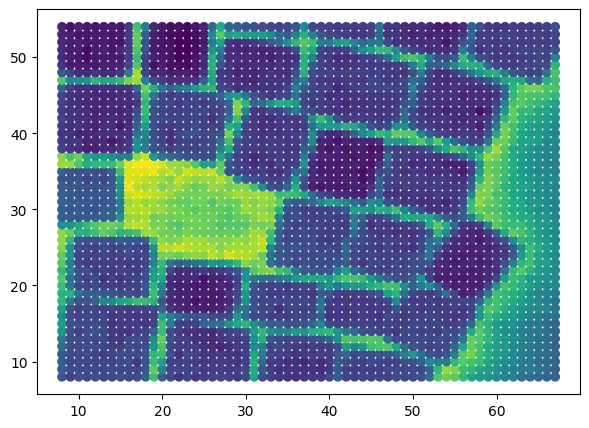

In [ ]:
# Let's visualize the Image. The pixel intesity here is the average of the spectrum
fig, ax = plt.subplots(figsize = (7,5))
ax.scatter(indices[:, 1], indices[:, 0], c=np.mean(targets, axis = 1))

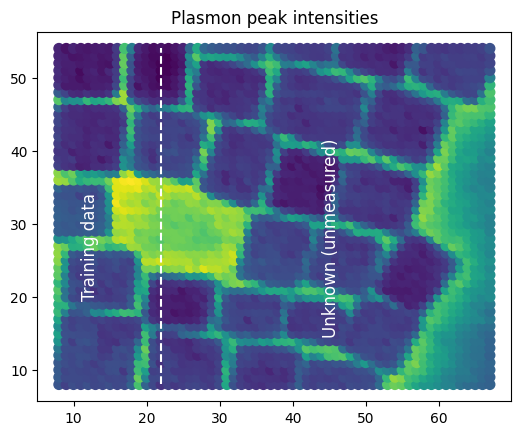

In [ ]:
# Here we will use the first 25 columns of the above plot as the training dataset
split_ = 22
X_train = X[indices[:, 1] <= split_]
y_train = y[indices[:, 1] <= split_]
indices_train = indices[indices[:, 1] < split_]

_, ax = plt.subplots()
ax.scatter(indices[:, 1], indices[:, 0], s=50, c=np.mean(targets, axis = 1))
ax.vlines(split_, indices[:, 0].min(), indices[:, 0].max(), linestyle='--', color='w')
ax.text(split_ // 2, 20, 'Training data', c='w', size=12, rotation=90)
ax.text((split_ + indices[:, 1].max()) // 2, 15, 'Unknown (unmeasured)', c='w', size=12, rotation=90)
ax.set_title('Plasmon peak intensities');
ax.set_aspect('equal')
plt.show()


In [ ]:
print(X_train.shape)
print(y_train.shape)


(705, 256)
(705, 46)


The comments are for running the DKL to predict a vector instead of a scalar.

1.   Notice here that we are sending the entire spectra as the output instead of the scalarizer
2.   Also, we are sending the transpose of the targets. This is to communicate the dimensionality of the targets to the DKL
3.   Internally, we will run 'N' DKLs parallely where each DKL "independently" predicts the output of one dimension of the target.
4.   Now pray to God that your GPU does not crash.

Comment for discussion: Does it make sense to fix the latent space and run N GPs instead of N DKLs? I am not yet capable of implementing this but is it possible



In [ ]:
data_dim = X_train.shape[-1]

key1, key2 = gpax.utils.get_keys()

dkl = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
# Read comments above
dkl.fit(key1, X_train, y_train.T, num_steps=100, step_size=0.05)  # Change hyperparameters as per the needs

init loss: 18964.910487337846, final loss (avg) [95-100]: 18226.1823 

Inferred GP kernel parameters
k_length         [[ 0.6113  0.5838]
 [ 1.114   0.9552]
 [ 2.4629  2.2549]
 [ 3.6939  3.5113]
 [ 5.5001  4.5905]
 [ 5.9236  8.2807]
 [ 7.4202  7.1978]
 [12.5878 18.2068]
 [13.464  16.5749]
 [15.8452 35.3167]
 [ 9.103  12.5063]
 [38.5777 30.1379]
 [18.6193 27.9863]
 [35.2815 34.738 ]
 [14.6888 16.0674]
 [18.0081 15.7094]
 [14.2091  8.8624]
 [11.3739  9.1496]
 [13.8592 11.3215]
 [13.453  10.7158]
 [ 6.9742  7.2902]
 [11.597   9.4893]
 [ 9.9967  8.0046]
 [ 7.0003  5.6077]
 [ 5.7058  5.7861]
 [ 4.8864  4.101 ]
 [ 4.4055  3.2956]
 [ 2.9791  3.4447]
 [ 1.2733  1.3265]
 [ 0.6102  0.588 ]
 [ 0.6124  0.5859]
 [ 0.6133  0.5914]
 [ 0.6197  0.6175]
 [ 0.6093  0.5741]
 [ 0.611   0.585 ]
 [ 0.6066  0.575 ]
 [ 0.613   0.5991]
 [ 0.6092  0.5931]
 [ 0.6082  0.5785]
 [ 0.6137  0.5938]
 [ 0.608   0.5763]
 [ 0.6111  0.593 ]
 [ 0.6229  0.6096]
 [ 0.6064  0.5779]
 [ 0.6148  0.5877]
 [ 0.61    0.5919]]
k_scale

In [ ]:
mean, var = dkl.predict_in_batches(key2, X, batch_size = 50)
mean = mean.T # Let's go back to shape of the output that we use conventionally (n_points, n_features)

Text(0.5, 1.0, 'DKL predictions of spectra ')

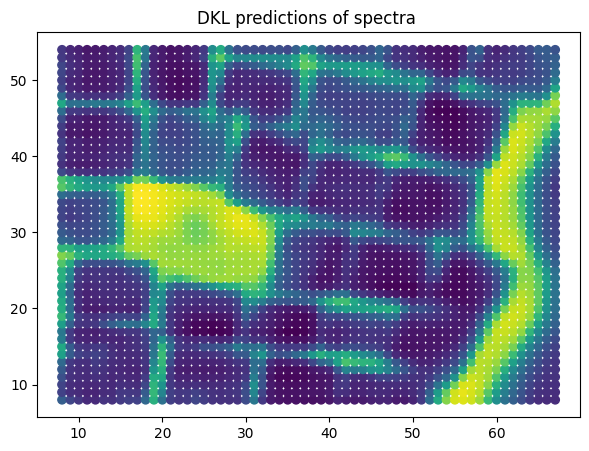

In [ ]:
# Visualizing the mean of the spectra as predicted by the DKL(s)

fig, ax = plt.subplots(figsize = (7,5))
ax.scatter(indices[:, 1], indices[:, 0], c=np.mean(mean, axis = 1))
ax.set_title("DKL predictions of spectra ")

Not bad. Let's now see how we use spectra as inputs and image patches as outputs

In [ ]:
data_dim1 = y_train.shape[-1] # Here the input is y_train

key11, key21 = gpax.utils.get_keys()

dkl1 = gpax.viDKL(data_dim1, z_dim=2, kernel='RBF')
# Read comments above
dkl1.fit(key11, y_train, X_train.T, num_steps=100, step_size=0.05)  # Change hyperparameters as per the needs

init loss: 6862.369590284245, final loss (avg) [95-100]: 6680.528600000001 

Inferred GP kernel parameters
k_length         [[0.3679 0.3822]
 [0.3679 0.3844]
 [0.3679 0.3824]
 [0.3679 0.3813]
 [0.3679 0.3797]
 [0.3679 0.3827]
 [0.3679 0.3843]
 [0.3679 0.3823]
 [0.5375 0.8805]
 [0.5139 0.7543]
 [0.3679 0.3778]
 [0.3679 0.375 ]
 [0.3679 0.3752]
 [0.3679 0.3734]
 [0.3679 0.3704]
 [0.368  0.3683]
 [0.3679 0.383 ]
 [0.3679 0.3859]
 [0.3679 0.384 ]
 [0.3679 0.3787]
 [0.8565 0.7542]
 [0.3679 0.3815]
 [0.3679 0.3826]
 [0.3679 0.382 ]
 [0.739  0.7823]
 [0.3679 0.3787]
 [0.3679 0.3797]
 [0.3679 0.3774]
 [0.3679 0.3784]
 [0.3679 0.3766]
 [0.3679 0.3749]
 [0.3679 0.3721]
 [0.3679 0.3866]
 [0.3679 0.3873]
 [0.3679 0.3874]
 [0.3679 0.3824]
 [0.3679 0.3797]
 [0.3679 0.3795]
 [0.3679 0.379 ]
 [0.6031 0.842 ]
 [1.612  0.6957]
 [0.6538 1.081 ]
 [0.8635 0.5414]
 [0.8552 1.2609]
 [0.788  0.8616]
 [0.6462 0.6503]
 [0.7314 0.6978]
 [0.4091 0.3692]
 [0.3679 0.3888]
 [0.3679 0.3901]
 [0.3679 0.3901]
 [0.3679 

In [ ]:
mean1, var1 = dkl1.predict_in_batches(key21, y, batch_size = 50)
mean1 = mean1.T # Let's go back to shape of the output that we use conventionally (n_points, n_features)

In [ ]:
print(mean1.shape) # Predicted image patches

(2820, 256)


# For future (MTDKL) via chatGPT

Need to understand these two scenarios and how they are different

# 1. Multi-Output Regression with viMTDKL
data_dim = X_train.shape[-1]  # 256 dimensions for input
num_tasks = y_train.shape[-1]  # 64 tasks (each output dimension is a task)

key1, key2 = gpax.utils.get_keys()

# Initialize viMTDKL model
# Assuming each task is independent and does not share the same input space
# with other tasks. If they do share, set `shared_input_space` to True.
mt_dkl = gpax.viMTDKL(input_dim=data_dim, z_dim=2, data_kernel='RBF',
                      num_latents=num_tasks, shared_input_space=False)

# Train the model
mt_dkl.fit(key1, X_train, y_train.T, num_steps=100, step_size=0.05)  # Adjust hyperparameters as needed

# 2. Single Task with Multivariate Output using viMTDKL
data_dim = X_train.shape[-1]  # 256 dimensions for input

key1, key2 = gpax.utils.get_keys()

# Initialize viMTDKL model
# Here, we're treating the entire 64-dimensional output as a single task.
# `num_latents` could be less than the dimensionality of the output,
# based on how complex the internal correlations are.
num_latents = 2  # This can be tuned based on your specific problem
mt_dkl = gpax.viMTDKL(input_dim=data_dim, z_dim=2, data_kernel='RBF',
                      num_latents=num_latents, shared_input_space=True,
                      num_tasks=1)  # `num_tasks=1` as it's a single task

# Train the model
mt_dkl.fit(key1, X_train, y_train.T, num_steps=100, step_size=0.05)  # Adjust hyperparameters as needed

